In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from randomization_proposals import experiment
import matplotlib.markers as markers
import matplotlib.lines as mlines

### Partial BF (Randomization Near Decision Boundary): Utility Difference

In [ ]:
res = []
for m in ["rf", "dt", "log"]:
    for i in tqdm(range(5)):
        d = pd.read_csv("../../data/census_results/ca_income_"+m+str(i)+".csv")
        e = experiment(d)
        r = e.exp_partial_bf_randomization_rate_utility(selection_rate=0.50, iterations=100)
        r["m"] = m
        res.append(r)
res = pd.concat(res)

In [ ]:
util_diff = []
for perc_random_n in np.linspace(0,1, 11):
    inner = []
    for perc_random_k in np.linspace(0,1, 11):
        if (perc_random_k == 0) and (perc_random_n != 0):
            inner.append(np.nan)
            continue
        elif (perc_random_k == 1) and (perc_random_n != 1):
            inner.append(np.nan)
            continue

        val = res.loc[(res["perc_random_k"]==perc_random_k)&(res["perc_random_n"]==perc_random_n), "random_util"].to_numpy()
        if len(val)>0:
            inner.append(np.abs(val[0]))
        else:
            inner.append(np.nan)
    util_diff.append(inner)

plt.rcParams["figure.figsize"] = [5, 4]
fig, ax = plt.subplots()

plt.imshow(util_diff, cmap='Greens', vmin=0.60, vmax=0.95, interpolation='nearest')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel('Randomization Rate: $k\'\\,$/$\\;k$')
ax.set_ylabel('Randomization Rate: $n\'\\,$/$\\;n$')

for (j,i),label in np.ndenumerate(util_diff):
    if pd.notna(label):        
        ax.text(i,j,"{:.2f}".format(label)[1:],ha='center',va='center')


ax.set_facecolor('w')
plt.tight_layout()
plt.savefig('census_partial_bf_5.jpg', format='jpg', dpi=500)
plt.show()

### Randomization Proposals: Utility

In [ ]:
res = []
for m in tqdm(["rf", "dt", "log"]):
    for i in range(5):
        d = pd.read_csv("../../data/census_results/ca_income_"+m+str(i)+".csv")
        e = experiment(d)
        r = e.exp_randomization_using_variance(selection_rate=0.50, iterations=100)
        r["m"] = m
        res.append(r)
res = pd.concat(res)

for m in ["log", "rf", "dt"]:
    print(m)
    temp = (res.loc[res["m"]==m].drop(columns=["m"])*100).mean().round(1)
    
    print(str(temp["perc_random_k"])+"\\% &",
          str(temp["perc_random_n"])+"\\% &",
          str(temp["random_util"])+"\\% &",
          str(temp["partial_bf_util"])+"\\% &",
          str(temp["determ_util"])+"\\%")
    print()
    print()

In [ ]:
res = []
for m in tqdm(["rf", "dt", "log"]):
    for i in range(5):
        d = pd.read_csv("../../data/census_results/ca_income_"+m+str(i)+".csv")
        e = experiment(d)
        r = e.exp_randomization_using_outliers(selection_rate=0.25, alpha=0.20, iterations=100)
        r["m"] = m
        res.append(r)
res = pd.concat(res)

for m in ["log", "rf", "dt"]:
    print(m)
    temp = (res.loc[res["m"]==m].drop(columns=["m"])*100).mean().round(1)
    
    print(str(temp["perc_random_k"])+"\\% &",
          str(temp["perc_random_n"])+"\\% &",
          str(temp["random_util"])+"\\% &",
          str(temp["partial_bf_util"])+"\\% &",
          str(temp["determ_util"])+"\\%")
    print()
    print()

### Randomization Proposals: SER

In [2]:
def get_proposal_ser(model, sr, noise, method, conformal_alpha=None):
    res = []
    for i in tqdm(range(5)):
        d = pd.read_csv("../../data/census_results/ca_income_"+model+str(i)+".csv")
        e = experiment(d)
        r = e.exp_systemic_exclusion(selection_rate=sr, noise_std=noise, num_decision_makers=4, iterations=100,
                                    randomization_method=method, alpha=conformal_alpha, perc_random_n=None, perc_random_k=None)
        res.append(r)
    res = pd.concat(res)
    res = res.groupby("m").mean().reset_index()
    return res["random_ser"].to_numpy()

def get_proposal_utility(model, sr, method, conformal_alpha=None):
    res = []
    for i in tqdm(range(5)):
        d = pd.read_csv("../../data/census_results/ca_income_"+model+str(i)+".csv")
        e = experiment(d)
        if method=="variance":
            r = e.exp_randomization_using_variance(selection_rate=SR, iterations=100)
        else:
            r = e.exp_randomization_using_outliers(selection_rate=SR, alpha=conformal_alpha, iterations=100)
        res.append(np.mean(r["random_util"]))
    return np.mean(res)

def get_partial_ser(model, sr, noise):
    res_ser = []
    for i in tqdm(range(5)):
        d = pd.read_csv("../../data/census_results/ca_income_"+model+str(i)+".csv")
        e = experiment(d)
        res_utility = e.exp_partial_bf_randomization_rate_utility(selection_rate=sr, iterations=5, linspace=21)
        rs = e.exp_partial_bf_randomization_rate_ser(selection_rate=sr, noise_std=noise, num_decision_makers=4, iterations=5, linspace=21)
        rs = rs.merge(res_utility, on=["perc_random_k", "perc_random_n"], how="left")
        rs = rs.groupby(["m", "perc_random_k", "perc_random_n"]).mean().reset_index()
        #rs["random_ser"] = rs["random_ser"].round(2)
        #rs["random_util"] = rs["random_util"].round(2)
        #rs = rs.groupby(["m", "random_util"]).min().reset_index()
        res_ser.append(rs)
    res_ser = pd.concat(res_ser)
    res_ser = res_ser.groupby(["m", "perc_random_k", "perc_random_n"]).mean().reset_index()
    return res_ser

In [11]:
SR = 0.50
CONFORMAL_ALPHA = 0.10
NOISE = 0

def fit_curve(raw_x, raw_y):
    model = np.polyfit(raw_x, raw_y, deg=2)
    x = np.linspace((1-SR)**5, (1-SR), 100)
    y = model[0]*(x**2) + model[1]*(x) + model[2]
    return x,y

In [12]:
res_ser = {}
for m in ["log", "rf", "dt"]:
    res_ser[m] = get_partial_ser(m, SR, NOISE)
    res_ser[m]["random_ser"] = res_ser[m]["random_ser"].round(3)
    res_ser[m]["random_util"] = res_ser[m]["random_util"].round(3)
    res_ser[m] = res_ser[m].groupby(["m", "random_util"]).min().reset_index()

100%|█████████████████████████████████████████████| 5/5 [05:19<00:00, 63.97s/it]


In [13]:
variance_utility = {}
variance_ser = {}
for m in ["log", "rf", "dt"]:
    variance_utility[m] = get_proposal_utility(model=m, sr=SR, method="variance", conformal_alpha=None)
    variance_ser[m] = get_proposal_ser(model=m, sr=SR, noise=NOISE, method="variance", conformal_alpha=None)

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


In [14]:
outliers_utility = {}
outliers_ser = {}
for m in ["log", "rf", "dt"]:
    outliers_utility[m] = get_proposal_utility(model=m, sr=SR, method="outliers", conformal_alpha=CONFORMAL_ALPHA)
    outliers_ser[m] = get_proposal_ser(model=m, sr=SR, noise=NOISE, method="outliers", conformal_alpha=CONFORMAL_ALPHA)

100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


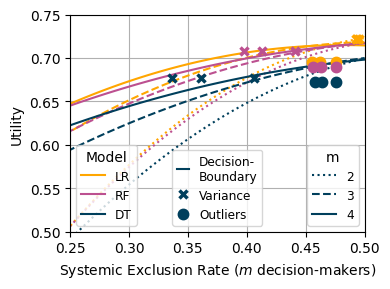

In [19]:
plt.rcParams["figure.figsize"] = [4,3]
fig, ax = plt.subplots()

colors = {
    "log": {2: "#ffa600", 3: "#ffa600", 4: "#ffa600"},
    "rf": {2: "#bc5090", 3: "#bc5090", 4: "#bc5090"},
    "dt": {2: "#003f5c", 3: "#003f5c", 4: "#003f5c"}
}

linestyle = {2: "dotted", 3: "dashed", 4: "solid"}

for model in ["log", "rf", "dt"]:
    for dm in [2, 3, 4]:
        x,y = fit_curve(res_ser[model].loc[res_ser[model]["m"]==dm, "random_ser"], res_ser[model].loc[res_ser[model]["m"]==dm, "random_util"])
        #plt.plot(res_ser[model].loc[res_ser[model]["m"]==dm, "random_ser"], res_ser[model].loc[res_ser[model]["m"]==dm, "random_util"], color=colors[model][dm], linestyle=linestyle[dm])
        if dm == 4 and model == "dt":
            plt.plot(x, y, color=colors[model][dm], linestyle=linestyle[dm], label="Decision-\nBoundary")
        else:
            plt.plot(x, y, color=colors[model][dm], linestyle=linestyle[dm])


for model in ["log", "rf", "dt"]:
    for i,dm in enumerate([2, 3, 4]):
        if dm == 4 and model == "dt":
            plt.plot(variance_ser[model][i], variance_utility[model], marker="x", color=colors[model][dm], markeredgewidth=2.5, linestyle='None', label="Variance")
        else:
            plt.plot(variance_ser[model][i], variance_utility[model], marker="x", color=colors[model][dm], markeredgewidth=2.5)

for model in ["log", "rf", "dt"]:
    for i,dm in enumerate([2, 3, 4]):
        if dm == 4 and model == "dt":
            plt.plot(outliers_ser[model][i], outliers_utility[model], marker="o", color=colors[model][dm], markeredgewidth=2.5, linestyle='None', label="Outliers")
        else:
            plt.plot(outliers_ser[model][i], outliers_utility[model], marker="o", color=colors[model][dm], markeredgewidth=2.5)


first_legend = plt.legend(loc="lower center", handlelength=1, fontsize=8.75)


#plt.plot(0.65, 0.63, marker="x", color="#003f5c", markeredgewidth=2.5)
#plt.plot(0.65, 0.6, marker="o", color="#003f5c", markeredgewidth=2.5)

plt.ylim([0.5, 0.75])
plt.xlim([0.25, 0.5])

blue_line = mlines.Line2D([], [], color="#003f5c", linestyle="dotted", label="2")
blue_line2 = mlines.Line2D([], [],  color="#003f5c", linestyle="dashed", label="3")
blue_line3 = mlines.Line2D([], [],  color="#003f5c", linestyle="solid", label="4")

second_legend = plt.legend(handles=[blue_line, blue_line2, blue_line3], title="m", loc="lower right", fontsize=8.75)

ax = plt.gca().add_artist(first_legend)
ax = plt.gca().add_artist(second_legend)

blue_line = mlines.Line2D([], [], color="#ffa600", linestyle="solid", label="LR")
blue_line2 = mlines.Line2D([], [],  color="#bc5090", linestyle="solid", label="RF")
blue_line3 = mlines.Line2D([], [],  color="#003f5c", linestyle="solid", label="DT")

plt.legend(loc="lower left", handles=[blue_line, blue_line2, blue_line3], title="Model", fontsize=8.75)

plt.xlabel("Systemic Exclusion Rate ($m$ decision-makers)")
plt.ylabel("Utility")

plt.grid()
plt.tight_layout()
plt.savefig('census_utility_ser_5.jpg', format='jpg', dpi=500)
plt.show()